In [1]:
from sklearn import linear_model
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# The Propublica/COMPAS Recidivism Data Set

## Loading the Data

Below, `allowed_factors` shows all of the data that the Propublica data set contains with 7214 people and 53 features. 

I have commented out the factors that are not relevant for predicting recidivism, not useful for debiasing, or not useful for measuring accuracy. 

If it is unclear what a variable is, I put a comment indicating what I think it is.

In [2]:
raw_data = pd.read_csv("./compas-scores-two-years.csv")
print('(#people, #features) =', raw_data.shape)

(#people, #features) = (7214, 53)


In [3]:
allowed_factors = [
 #'id',
 #'name',
 #'first',
 #'last',
 #'compas_screening_date',
 #'sex',
 #'dob',
 #'age',
 #'age_cat',
 'race',
 'decile_score', #COMPAS score
 'juv_fel_count', 
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 #'days_b_screening_arrest', propublica uses this to filter data
#  'c_jail_in', date
#  'c_jail_out', date
#  'c_case_number',
#  'c_offense_date',
#  'c_arrest_date',
#  'c_days_from_compas',
 'c_charge_degree', #Misdemeanor or felony for original charge, need to make categorical
 #'c_charge_desc',
 'is_recid', 
 #'r_case_number',
 'r_charge_degree',#Misdemeanor or felony of re-offense, need to make categorical
#  'r_days_from_arrest',
#  'r_offense_date',
#  'r_charge_desc',
#  'r_jail_in',
#  'r_jail_out',
 #'violent_recid', #all are NAN
 'is_violent_recid', #hey we can use this for groups!
#  'vr_case_number',
 'vr_charge_degree', #maybe remove this from r_charge degree
#  'vr_offense_date',
#  'vr_charge_desc', #weird that vr_charge_desc and r_charge_desc do not overlap
#  'type_of_assessment',
#  'decile_score.1',#same as decile score?
  'score_text',#low, medium, high risk based on COMPAS
#  'screening_date',
#  'v_type_of_assessment',
#  'v_decile_score',
#  'v_score_text', #low, medium high
#  'v_screening_date',
#  'in_custody',
#  'out_custody',
 #'priors_count.1', #not sure what the dif is from priors_count. it is the same
#  'start',
#  'end',
# 'event', #no clue what this means?!?
 #'two_year_recid' # same as is_recid
] 

In [4]:
allowed_factors

['race',
 'decile_score',
 'juv_fel_count',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'c_charge_degree',
 'is_recid',
 'r_charge_degree',
 'is_violent_recid',
 'vr_charge_degree',
 'score_text']

If you want to see what the other columns of `raw_data` are, play with the below cell:

In [5]:
raw_data[['vr_charge_degree', 'r_charge_degree']]

,vr_charge_degree,r_charge_degree
0,NaN,NaN
1,(F3),(F3)
2,NaN,(M1)
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,(F2)
7,NaN,NaN
8,NaN,NaN
9,(F2),(M1)


I have filtered the data just as Propublica has [here](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb) but also, I only include African Americans and Caucasians leaving $\sim$ 5000 people.

In [6]:
filtered_data = raw_data.loc[(raw_data['is_recid'] != -1) & 
                             (raw_data['days_b_screening_arrest'] <=30) &
                             (raw_data['days_b_screening_arrest'] >=-30) &
                             (raw_data['c_charge_degree'] != 'O') &
                             (raw_data['score_text'] != 'N/A') &
                             (raw_data['race'].isin(['African-American', 'Caucasian']))
                            ]
final_data = filtered_data[allowed_factors]
print('the dimensions of final_data are', final_data.shape)

the dimensions of final_data are (5278, 12)


## Now we need to shuffle the data and split it into 3 pieces:
<ol>
  <li>A debiasing train set we use to debias the data.</li>
  <li>A training set to train logistic regression.</li>
  <li>A test set to measure false positive rates, false negative rates, etc.</li>
</ol>

In [66]:
def shuffle_and_split_data(final_data, debias_train_size, standard_training_set_percentage):
    # shuffle data
    final_data = final_data.sample(frac=1).reset_index(drop=True)
    
    # get data
    # Y contains 'is_recid','r_charge_degree','is_violent_recid','vr_charge_degree',
    Y = final_data[allowed_factors].values[:, 7:11] 
    
    # X contains 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count','c_charge_degree',
    X = final_data[allowed_factors].values[:, 2:7]
    
    #contains compas scores ranging from 1-10
    compas = final_data[allowed_factors].values[:, 1]
    race = final_data[allowed_factors].values[:, 0]
    
    #contains low, medium, high risk from compas scores
    score_text = final_data[allowed_factors].values[:, 11]

    # change Misdemeanor/Felony to 0/1
    keys = {}
    value = 0;
    for t,i in enumerate(X[:,4]):
        if i not in keys:
            keys[i] = value
            value +=1
        X[t, 4] = keys[i]

    #split data into debias train; train; test
    train_size = math.floor((X.shape[0] - debias_train_size)*standard_training_set_percentage)
    test_size = (X.shape[0] - debias_train_size) - math.floor((X.shape[0] - debias_train_size)*standard_training_set_percentage)

    X_debias_train = X[0:debias_train_size, :]
    Y_debias_train = Y[0:debias_train_size, :]
    race_debias_train = race[0:debias_train_size]


    X_train = X[debias_train_size : debias_train_size + train_size, : ]
    Y_train = Y[debias_train_size : debias_train_size + train_size, : ]
    race_train = race[debias_train_size : debias_train_size + train_size ]

    X_test = X[debias_train_size + train_size:, :]
    Y_test = Y[debias_train_size + train_size:, :]
    compas_test = compas[debias_train_size + train_size:]
    race_test = race[debias_train_size + train_size:]
    
    return X_debias_train, Y_debias_train, race_debias_train, X_train, Y_train, race_train, X_test, Y_test, compas_test, race_test

## Logistic Regression as a proxy to COMPAS

We use logistic regression.

In [8]:
def fit_logistic_regression(X_train, Y_train):
    #had to do this because of some error...
    y = [int(Y_train[i,0]) for i in range(Y_train.shape[0])]

    lr = linear_model.LogisticRegression()
    lr.fit(X_train,y)
    w = lr.coef_
    w = np.array(w)
    b = lr.intercept_
    return w,b

def logistic(w, X, b):
    return 1/(1+ math.exp(-(np.dot(w,X.T) + b)))

def logistic_histogram(X, race, w,b):
    probabilities = [logistic(w, X[i,:],b) for i in range(X.shape[0])]
    print('the avg is', np.mean(probabilities))
    print('the median is', np.median(probabilities))
    plt.hist(probabilities, bins = 25)
    plt.title("Histogram of Probabilities of Recidivism from Logistic Regression on Test Set")
    plt.xlabel("probability from logistic regression")
    plt.ylabel("Number of people")
    plt.show()

    print('Notice the difference in scale on the y-axis!')
    probabilities_AA = [logistic(w, X[i,:],b) for i in range(X.shape[0]) if race[i] == 'African-American']
    probabilities_white = [logistic(w, X[i,:],b) for i in range(X.shape[0]) if race[i] == 'Caucasian']
    plt.subplot(1,2,1)
    plt.hist(probabilities_AA, bins = 25)
    plt.title("Histogram of Probabilities \n of Recidivism for African-Americans \n under Logistic Regression \n on Test Set")
    plt.xlabel("probability from logistic regression")
    plt.ylabel("Number of African-Americans")

    plt.subplot(1,2,2)
    plt.hist(probabilities_white, bins = 25)
    plt.title("Histogram of Probabilities \n of Recidivism for Caucasians \n under Logistic Regression \n on Test Set")

    plt.xlabel("probability from logistic regression")
    plt.ylabel("Number of Caucasians")
    plt.tight_layout()
    plt.show()

## Debiasing Features

We assume that the data $Y = X A^T + Z B^T + E$, where $X$ is protected attributes like gender, $Z$ are unknown but are "discriminative" attributes and $E$ is an error term. 

We partition the rows of $Y$ into 3 "homogeneous groups": 
<ol>
  <li>Those who have committed a **non-violent** crime within 2 years.</li>
  <li>Those who have committed a **violent** crime within 2 years</li>
  <li>Those who have **not** committed a crime after 2 years.</li>
</ol>

To debias the data, we use least squares to estimate $A$.

In [64]:
def race_dummy(race_debias_train, race_train, race_test):
    # express race (black and white) as two dummy variables 
    white_dict = {'Caucasian': 1, 'African-American':0}
    black_dict = {'Caucasian': 0, 'African-American':1}
    
    white_debias_train = np.array([white_dict[i] for i in race_debias_train]).reshape((-1,1))
    black_debias_train = np.array([black_dict[i] for i in race_debias_train]).reshape((-1,1))
    race_debias_train = np.concatenate((white_debias_train, black_debias_train), axis = 1)

    white_train = np.array([white_dict[i] for i in race_train]).reshape((-1,1))
    black_train = np.array([black_dict[i] for i in race_train]).reshape((-1,1))
    race_dummy_train = np.concatenate((white_train, black_train), axis = 1)

    white_test = np.array([white_dict[i] for i in race_test]).reshape((-1,1))
    black_test = np.array([black_dict[i] for i in race_test]).reshape((-1,1))
    race_dummy_test = np.concatenate((white_test, black_test), axis = 1)
    return race_debias_train, race_dummy_train, race_dummy_test

In [10]:
# 'is_recid',
#  'r_charge_degree',
#  'is_violent_recid', you can check if everyone has a degree
#  'vr_charge_degree',
def get_centered_X(X_train, Y_train):
    #get average race in each group
    # nonviolent_avg_race_train = np.mean(np.array([race_encoded_train[i] for i in range(len(race_encoded_train)) if Y_train[i,0] == 1 and Y_train[i,2]==0]))
    # violent_avg_race_train = np.mean(np.array([race_encoded_train[i] for i in range(len(race_encoded_train)) if Y_train[i,2]==1]))
    # nonrecidiv_avg_race_train = np.mean(np.array([race_encoded_train[i] for i in range(len(race_encoded_train)) if Y_train[i,0]==0]))

    #get average "Y" in alg 1 in our paper for each group
    nonviolent_avg_X_train = np.zeros(X_train.shape[1])
    count = 0
    for i in range(X_train.shape[0]):
        if Y_train[i,0] == 1 and Y_train[i,2] == 0:
            count +=1
            nonviolent_avg_X_train = np.add(nonviolent_avg_X_train,X_train[i,:])

    nonviolent_avg_X_train = nonviolent_avg_X_train/count
    ############################################
    violent_avg_X_train = np.zeros(X_train.shape[1])
    count = 0
    for i in range(X_train.shape[0]):
        if Y_train[i,2] == 1:
            count +=1
            violent_avg_X_train = np.add(violent_avg_X_train,X_train[i,:])

    violent_avg_X_train = violent_avg_X_train/count
    ###########################################
    nonrecidiv_avg_X_train = np.zeros(X_train.shape[1])
    count = 0
    for i in range(X_train.shape[0]):
        if Y_train[i,2] == 1:
            count +=1
            nonrecidiv_avg_X_train = np.add(nonrecidiv_avg_X_train,X_train[i,:])

    nonrecidiv_avg_X_train = nonrecidiv_avg_X_train/count

    #get centered matrices
    #race_encoded_train_centered = np.zeros(race_encoded_train.shape)
    X_train_centered = X_train
    for i in range(X_train.shape[0]):
        if Y_train[i,0] == 1 and Y_train[i,2] == 0:
            #race_encoded_train_centered[i,0] = race_encoded_train[i,0] - nonviolent_avg_race_train
            X_train_centered[i,:] = np.copy(np.subtract(X_train_centered[i,:], nonviolent_avg_X_train))
        elif Y_train[i,2] == 1:
            #race_encoded_train_centered[i,0] = race_encoded_train[i,0] - violent_avg_race_train
            X_train_centered[i,:] = np.copy(np.subtract(X_train_centered[i,:], violent_avg_X_train))
        else:
            #race_encoded_train_centered[i,0] = race_encoded_train[i,0] - nonrecidiv_avg_race_train
            X_train_centered[i,:] = np.copy(np.subtract(X_train_centered[i,:], nonrecidiv_avg_X_train))
    return X_train_centered

In [11]:
# 'is_recid',
#  'r_charge_degree',
#  'is_violent_recid', you can check if everyone has a degree
#  'vr_charge_degree',
def get_centered_X_refined(X_train, Y_train):
    #get average race in each group
    # nonviolent_avg_race_train = np.mean(np.array([race_encoded_train[i] for i in range(len(race_encoded_train)) if Y_train[i,0] == 1 and Y_train[i,2]==0]))
    # violent_avg_race_train = np.mean(np.array([race_encoded_train[i] for i in range(len(race_encoded_train)) if Y_train[i,2]==1]))
    # nonrecidiv_avg_race_train = np.mean(np.array([race_encoded_train[i] for i in range(len(race_encoded_train)) if Y_train[i,0]==0]))

    #get average "Y" in alg 1 in our paper for each group
    nonviolent_M_avg_X_train = np.zeros(X_train.shape[1])
    count = 0
    for i in range(X_train.shape[0]):
        if Y_train[i,0] == 1 and Y_train[i,2] == 0 and Y_train[i,1] in ['(M1)', '(M2)','(M3)']:
            count +=1
            nonviolent_M_avg_X_train = np.add(nonviolent_M_avg_X_train,X_train[i,:])
    print(count)
    nonviolent_M_avg_X_train = nonviolent_M_avg_X_train/count
    ############################################
    nonviolent_F_avg_X_train = np.zeros(X_train.shape[1])
    count = 0
    for i in range(X_train.shape[0]):
        if Y_train[i,0] == 1 and Y_train[i,2] == 0 and Y_train[i,1] in ['(F1)', '(F2)','(F3)']:
            count +=1
            nonviolent_F_avg_X_train = np.add(nonviolent_F_avg_X_train,X_train[i,:])
    print(count)
    nonviolent_F_avg_X_train = nonviolent_F_avg_X_train/count
    ############################################
    violent_M_avg_X_train = np.zeros(X_train.shape[1])
    count = 0
    for i in range(X_train.shape[0]):
        if Y_train[i,2] == 1 and Y_train[i,3] in ['(M1)', '(M2)','(M3)']:
            count +=1
            violent_M_avg_X_train = np.add(violent_M_avg_X_train,X_train[i,:])
    print(count)
    violent_M_avg_X_train = violent_M_avg_X_train/count
    ###########################################
    violent_F_avg_X_train = np.zeros(X_train.shape[1])
    count = 0
    for i in range(X_train.shape[0]):
        if Y_train[i,2] == 1 and Y_train[i,3] in ['(F1)', '(F2)','(F3)']:
            count +=1
            violent_F_avg_X_train = np.add(violent_F_avg_X_train,X_train[i,:])
    print(count)
    violent_F_avg_X_train = violent_F_avg_X_train/count
    ###########################################
    nonrecidiv_avg_X_train = np.zeros(X_train.shape[1])
    count = 0
    for i in range(X_train.shape[0]):
        if Y_train[i,2] == 1:
            count +=1
            nonrecidiv_avg_X_train = np.add(nonrecidiv_avg_X_train,X_train[i,:])
    print(count)
    nonrecidiv_avg_X_train = nonrecidiv_avg_X_train/count

    #get centered matrices
    #race_encoded_train_centered = np.zeros(race_encoded_train.shape)
    X_train_centered = X_train
    for i in range(X_train.shape[0]):
        if Y_train[i,0] == 1 and Y_train[i,2] == 0 and Y_train[i,1] in ['(M1)', '(M2)','(M3)']:
            #race_encoded_train_centered[i,0] = race_encoded_train[i,0] - nonviolent_avg_race_train
            X_train_centered[i,:] = np.copy(np.subtract(X_train_centered[i,:], nonviolent_M_avg_X_train))
        elif Y_train[i,0] == 1 and Y_train[i,2] == 0 and Y_train[i,1] in ['(F1)', '(F2)','(F3)']:
            #race_encoded_train_centered[i,0] = race_encoded_train[i,0] - nonviolent_avg_race_train
            X_train_centered[i,:] = np.copy(np.subtract(X_train_centered[i,:], nonviolent_F_avg_X_train))
        elif Y_train[i,2] == 1 and Y_train[i,3] in ['(M1)', '(M2)','(M3)']:
            #race_encoded_train_centered[i,0] = race_encoded_train[i,0] - violent_avg_race_train
            X_train_centered[i,:] = np.copy(np.subtract(X_train_centered[i,:], violent_M_avg_X_train))
        elif Y_train[i,2] == 1 and Y_train[i,3] in ['(F1)', '(F2)','(F3)']:
            #race_encoded_train_centered[i,0] = race_encoded_train[i,0] - violent_avg_race_train
            X_train_centered[i,:] = np.copy(np.subtract(X_train_centered[i,:], violent_F_avg_X_train))
        else:
            #race_encoded_train_centered[i,0] = race_encoded_train[i,0] - nonrecidiv_avg_race_train
            X_train_centered[i,:] = np.copy(np.subtract(X_train_centered[i,:], nonrecidiv_avg_X_train))
    return X_train_centered

In [61]:
def get_A_hat(race_dummy_train, X_train_centered, fit_intercept):
    ols = linear_model.LinearRegression(fit_intercept)
    ols.fit(race_dummy_train, X_train_centered)
    A_hat = ols.coef_
    b = ols.intercept_
    return A_hat, b

## Quality of logistic regression trained on biased or debiased data & comparison to COMPAS

First, we look at the distribution of probabilities assigned by logistic regression on the whole population and on both the white and black population separately for one split on both the biased and debiased data set.

BIASED DATA:
the avg is 0.498589801369
the median is 0.438895511817


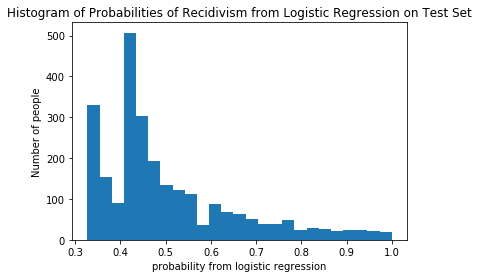

Notice the difference in scale on the y-axis!


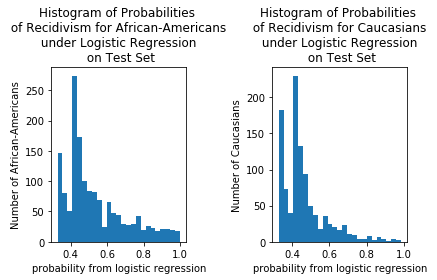

DEBIASED DATA:
the avg is 0.499915582507
the median is 0.460123852988


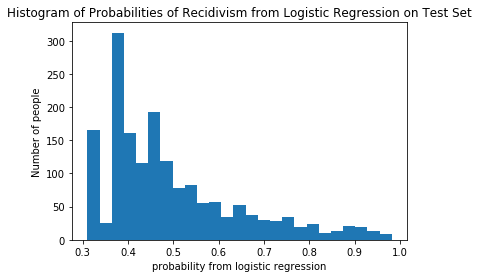

Notice the difference in scale on the y-axis!


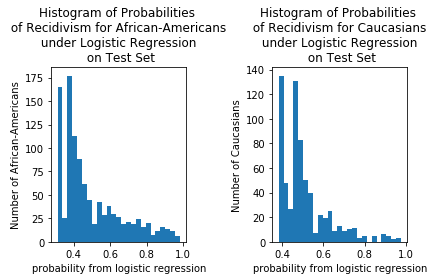

In [81]:
X_debias_train, Y_debias_train, race_debias_train, X_train, Y_train, race_train, X_test, Y_test, compas_test, race_test = shuffle_and_split_data(final_data,1000, .6)
w,b = fit_logistic_regression(X_train, Y_train)
print('BIASED DATA:')
logistic_histogram(X_train, race_train, w,b)

print('DEBIASED DATA:')
# X_debias_train = X_train - np.dot(race_encoded_train,A_hat.T)
# X_debias_test = X_test - np.dot(race_encoded_test, A_hat.T)
race_dummy_debias_train, race_dummy_train, race_dummy_test = race_dummy(race_debias_train, race_train, race_test)


#debias
#X_debias_train_centered = get_centered_X_refined(X_debias_train, Y_debias_train)
X_debias_train_centered = get_centered_X(X_debias_train, Y_debias_train)
A_hat, b = get_A_hat(race_dummy_debias_train, X_debias_train_centered, True)
X_post_debias_train = X_train - np.dot(race_dummy_train,A_hat.T) - b
X_post_debias_test = X_test - np.dot(race_dummy_test, A_hat.T) - b

#train
w, b = fit_logistic_regression(X_post_debias_train, Y_train)
logistic_histogram(X_post_debias_test, race_test, w, b)

Now we look at ROC also under the same scenarios above.

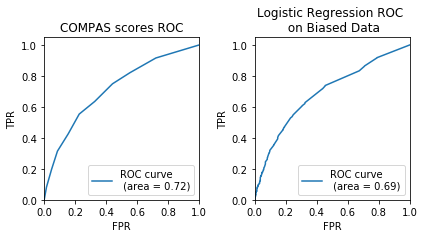

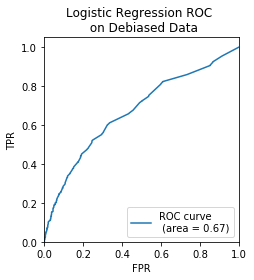

In [86]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

X_debias_train, Y_debias_train, race_debias_train, X_train, Y_train, race_train, X_test, Y_test, compas_test, race_test = shuffle_and_split_data(final_data,1000, .6)
race_dummy_debias_train, race_dummy_train, race_dummy_test = race_dummy(race_debias_train, race_train, race_test)
w,b = fit_logistic_regression(X_train, Y_train)
probabilities = [logistic(w, X_test[i,:],b) for i in range(X_test.shape[0])]


#debias
#X_debias_train_centered = get_centered_X_refined(X_debias_train, Y_debias_train)
X_debias_train_centered = get_centered_X(X_debias_train, Y_debias_train)
A_hat, b = get_A_hat(race_dummy_debias_train, X_debias_train_centered, True)
X_post_debias_train = X_train - np.dot(race_dummy_train,A_hat.T) - b
X_post_debias_test = X_test - np.dot(race_dummy_test, A_hat.T) - b

#train
w, b = fit_logistic_regression(X_post_debias_train, Y_train)
probabilities_debiased = [logistic(w, X_post_debias_test[i,:],b) for i in range(X_post_debias_test.shape[0])]


compasFpr, compasTpr, _ = roc_curve(Y_test[:,0].astype(int), compas_test)
compasRocAuc = auc(compasFpr, compasTpr)

logisticFpr, logisticTpr, _ = roc_curve(Y_test[:,0].astype(int), probabilities)
logisticRocAuc = auc(logisticFpr, logisticTpr)

logisticFpr_debiased, logisticTpr_debiased, _ = roc_curve(Y_test[:,0].astype(int), probabilities_debiased)
logisticRocAuc_debiased = auc(logisticFpr_debiased, logisticTpr_debiased)


plt.figure()
plt.subplot(1,2,1)
plt.plot(compasFpr, compasTpr, label='ROC curve \n (area = %0.2f)' % compasRocAuc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('COMPAS scores ROC')
plt.legend(loc="lower right")
plt.gca().set_aspect('equal', adjustable='box')
#plt.show()

plt.subplot(1,2,2)
plt.plot(logisticFpr, logisticTpr, label='ROC curve \n (area = %0.2f)' % logisticRocAuc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Logistic Regression ROC \n on Biased Data')
plt.legend(loc="lower right")
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

plt.figure()
plt.plot(logisticFpr_debiased, logisticTpr_debiased, label='ROC curve \n (area = %0.2f)' % logisticRocAuc_debiased)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Logistic Regression ROC \n on Debiased Data')
plt.legend(loc="lower right")
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [89]:
def FPR_FNR(X, Y, w, b, race, compas,logistic_prob_threshold =.5, compass_score_threshold = 5, verbose = False):
    probabilities = [logistic(w, X[i,:],b) for i in range(X.shape[0])]
    num_true_pos = 0
    num_COMP_FP = 0
    num_COMP_TP = 0
    num_LR_FP = 0
    num_LR_TP = 0
    num_true_neg = 0
    num_COMP_FN = 0
    num_COMP_TN = 0 
    num_LR_FN = 0
    num_LR_TN = 0 

    #for whites
    num_true_pos_W = 0
    num_true_neg_W = 0
    num_true_pos_W = 0
    num_COMP_FP_W = 0
    num_COMP_TP_W = 0
    num_LR_FP_W = 0
    num_LR_TP_W = 0
    num_true_neg_W = 0
    num_COMP_FN_W = 0
    num_COMP_TN_W = 0 
    num_LR_FN_W = 0
    num_LR_TN_W = 0 

    #for blacks
    num_true_pos_B = 0
    num_true_neg_B = 0
    num_true_pos_B = 0
    num_COMP_FP_B = 0
    num_COMP_TP_B = 0
    num_LR_FP_B = 0
    num_LR_TP_B = 0
    num_true_neg_B = 0
    num_COMP_FN_B = 0
    num_COMP_TN_B = 0 
    num_LR_FN_B = 0
    num_LR_TN_B = 0 

    #sorry this is ugly. i prob could have made it better :/
    for i in range(Y.shape[0]):
        if Y[i,0] == 0:
            num_true_neg +=1
            if race[i] == 'Caucasian':
                num_true_neg_W +=1
            else:
                num_true_neg_B +=1
            #compass
            if int(compas[i]) >= compass_score_threshold:
                num_COMP_FP +=1
                if race[i] == 'Caucasian':
                    num_COMP_FP_W +=1
                else:
                    num_COMP_FP_B +=1
            else: 
                num_COMP_TN +=1
                if race[i] == 'Caucasian':
                    num_COMP_TN_W +=1
                else:
                    num_COMP_TN_B +=1

            #logistic
            if probabilities[i] > logistic_prob_threshold:
                num_LR_FP +=1
                if race[i] == 'Caucasian':
                    num_LR_FP_W +=1
                else:
                    num_LR_FP_B +=1
            else: 
                num_LR_TN +=1
                if race[i] == 'Caucasian':
                    num_LR_TN_W +=1
                else:
                    num_LR_TN_B +=1

        elif Y[i,0] == 1:
            num_true_pos += 1
            if race[i] == 'Caucasian':
                num_true_pos_W +=1
            else:
                num_true_pos_B +=1
            #compass
            if int(compas[i]) < compass_score_threshold:
                num_COMP_FN +=1
                if race[i] == 'Caucasian':
                    num_COMP_FN_W +=1
                else:
                    num_COMP_FN_B +=1
            else:
                num_COMP_TP +=1
                if race[i] == 'Caucasian':
                    num_COMP_TP_W +=1
                else:
                    num_COMP_TP_B +=1


            #logistic
            if probabilities[i] < logistic_prob_threshold:
                num_LR_FN +=1
                if race[i] == 'Caucasian':
                    num_LR_FN_W +=1
                else:
                    num_LR_FN_B +=1            
            else:
                num_LR_TP +=1
                if race[i] == 'Caucasian':
                    num_LR_TP_W +=1
                else:
                    num_LR_TP_B +=1
    FPR_C = num_COMP_FP / num_true_neg
    FNR_C = num_COMP_FN / num_true_pos
    FPR_C_W = num_COMP_FP_W / (num_COMP_FP_W + num_COMP_TN_W)
    FNR_C_W = num_COMP_FN_W / (num_COMP_FN_W + num_COMP_TP_W)
    FPR_C_B = num_COMP_FP_B / (num_COMP_FP_B + num_COMP_TN_B)
    FNR_C_B = num_COMP_FN_B / (num_COMP_FN_B + num_COMP_TP_B)
    FPR_LR = num_LR_FP / num_true_neg
    FNR_LR = num_LR_FN / num_true_pos
    FPR_LR_W = num_LR_FP_W / (num_LR_FP_W + num_LR_TN_W)
    FNR_LR_W = num_LR_FN_W / (num_LR_FN_W + num_LR_TP_W)
    FPR_LR_B = num_LR_FP_B / (num_LR_FP_B + num_LR_TN_B)
    FNR_LR_B = num_LR_FN_B / (num_LR_FN_B + num_LR_TP_B)

    
    if verbose == True:
        print('There are', num_true_neg, 'people who did NOT recidivate within 2 years on the test set.')
        print('There are', num_true_pos, 'people who DID recidivate within 2 years on the test set.', '\n')

        print('There are', num_true_neg_W, 'Caucasians who did NOT recidivate within 2 years on the test set.')
        print('There are', num_true_pos_W, 'Caucasians who DID recidivate within 2 years on the test set.', '\n')

        print('There are', num_true_neg_B, 'African-Americans who did NOT recidivate within 2 years on the test set.')
        print('There are', num_true_pos_B, 'African-Americans who DID recidivate within 2 years on the test set.', '\n')
        print('--------------------------------------------------------------------------------------')
        print('The COMPAS false positive rate on the entire test set is', num_COMP_FP / (num_true_neg))
        print('The COMPAS false negative rate on the entire test set is', num_COMP_FN / (num_true_pos), '\n')

        print('The COMPAS false positive rate on Caucasians in the test set is', num_COMP_FP_W / (num_COMP_FP_W + num_COMP_TN_W))
        print('The COMPAS false negative rate on Caucasians in the test set is', num_COMP_FN_W / (num_COMP_FN_W + num_COMP_TP_W), '\n')

        print('The COMPAS false positive rate on African-Americans in the test set is', num_COMP_FP_B / (num_COMP_FP_B + num_COMP_TN_B))
        print('The COMPAS false negative rate on African-Americans in the test set is', num_COMP_FN_B / (num_COMP_FN_B + num_COMP_TP_B), '\n')
        print('--------------------------------------------------------------------------------------')
        print('Logistic Regression false positive rate on the entire test set is', num_LR_FP / (num_true_neg))
        print('Logistic Regression false negative rate on the entire test set  is', num_LR_FN / (num_true_pos), '\n')

        print('Logistic Regression false positive rate on Caucasians in the test set is', num_LR_FP_W / (num_LR_FP_W + num_LR_TN_W))
        print('Logistic Regression false negative rate on Caucasians in the test set is', num_LR_FN_W / (num_LR_FN_W + num_LR_TP_W), '\n')

        print('Logistic Regression false positive rate on African-Americans in the test set is', num_LR_FP_B / (num_LR_FP_B + num_LR_TN_B))
        print('Logistic Regression false negative rate on African-Americans in the test set is', num_LR_FN_B / (num_LR_FN_B + num_LR_TP_B), '\n')
    
    rates = [FPR_C, FNR_C, FPR_LR, FNR_LR, FPR_C_W, FNR_C_W, FPR_LR_W, FNR_LR_W, FPR_C_B, FNR_C_B, FPR_LR_B, FNR_LR_B] 

    return np.array(rates)    

We compare false positive and false negative rates (FPR, FNR) over the total population, the Caucasian subpopulation, and the African-American subpopulation of our logistic regression model and COMPAS scores. We do this comparison over multiple splits of the data set and average FPR, FNR. 

We comment that we are able to approximately reproduce Propublica's fidings about the discrepancy of FPR and FNR over race as discussed [here](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).

By chosing the threshold for logistic regression appropriately (i.e. at what threshold to start flagging people for risk of recidivism based on logistic regression), we are able to get relatively close to the same FNR, FPR rates as COMPAS on the biased data set.

In [94]:
num_splits = 30
logistic_reg_threshold_biased = .45
logistic_reg_threshold_debiased = .58
compas_score_threshold = 5

rates_biased = np.zeros((num_splits,12))
rates_debiased = np.zeros((num_splits,12))
for i1 in range(num_splits):
    X_debias_train, Y_debias_train, race_debias_train, X_train, Y_train, race_train, X_test, Y_test, compas_test, race_test = shuffle_and_split_data(final_data,1000, .6)
    race_dummy_debias_train, race_dummy_train, race_dummy_test = race_dummy(race_debias_train, race_train, race_test)
    w, b = fit_logistic_regression(X_train, Y_train)
    rates_biased[i1,] = FPR_FNR(X_test, Y_test, w,b,race_test, compas_test,logistic_reg_threshold_biased, compas_score_threshold, False)
    #debias
    #X_debias_train_centered = get_centered_X_refined(X_debias_train, Y_debias_train)
    X_debias_train_centered = get_centered_X(X_debias_train, Y_debias_train)
    A_hat, b = get_A_hat(race_dummy_debias_train, X_debias_train_centered, True)
    X_post_debias_train = X_train - np.dot(race_dummy_train,A_hat.T) - b
    X_post_debias_test = X_test - np.dot(race_dummy_test, A_hat.T) - b

    #train
    w, b = fit_logistic_regression(X_post_debias_train, Y_train)
    rates_debiased[i1,] = FPR_FNR(X_post_debias_test, Y_test, w, b, race_test, compas_test, logistic_reg_threshold_debiased, compas_score_threshold, False)

rate_debiased = np.mean(rates_debiased, axis=0)
rate_biased = np.mean(rates_biased, axis=0)
se_debiased = np.std(rates_debiased, axis=0)
se_biased = np.std(rates_biased, axis=0)

dfMatBiased = np.zeros((3,8))
dfMatBiased[:,0:7:2] = np.reshape(rate_biased,(3,4)).round(2)
dfMatBiased[:,1:8:2] = np.reshape(se_biased,(3,4)).round(2)
dfMatBiased = dfMatBiased[:,(0, 2, 4,5,6,7)]

dfMatDebiased = np.zeros((3,8))
dfMatDebiased[:,0:7:2] = np.reshape(rate_debiased,(3,4)).round(2)
dfMatDebiased[:,1:8:2] = np.reshape(se_debiased,(3,4)).round(2)
dfMatDebiased = dfMatDebiased[:,(0, 2, 4,5,6,7)]

print('WITHOUT DEBIASING averaged over', num_splits, 'splits of the data:')
df = pd.DataFrame(np.concatenate((np.reshape(np.array(["FPR", "FNR", "FPR", "FPR SE", "FNR", "FNR SE"]), (1,6)), dfMatBiased)), index= ["", "population", "Caucasians", "African-Americans"], columns=["COMPAS", "", "", "Logistic", "Regression", ""])
print(df)
print('-----------')
print('WITH DEBIASING averaged over', num_splits, 'splits of the data:')
df = pd.DataFrame(np.concatenate((np.reshape(np.array(["FPR", "FNR", "FPR", "FPR SE", "FNR", "FNR SE"]), (1,6)), dfMatDebiased)), index= ["", "population", "Caucasians", "African-Americans"], columns=["COMPAS", "", "", "Logistic", "Regression", ""])
print(df)

WITHOUT DEBIASING averaged over 30 splits of the data:
                  COMPAS             Logistic Regression        
                     FPR   FNR   FPR   FPR SE        FNR  FNR SE
population          0.32  0.36  0.32     0.02       0.38    0.02
Caucasians          0.22  0.51  0.27     0.03       0.48    0.03
African-Americans   0.42  0.29  0.37     0.03       0.32    0.03
-----------
WITH DEBIASING averaged over 30 splits of the data:
                  COMPAS             Logistic Regression        
                     FPR   FNR   FPR   FPR SE        FNR  FNR SE
population          0.32  0.36  0.13     0.02       0.64    0.02
Caucasians          0.22  0.51  0.12     0.02       0.68    0.04
African-Americans   0.42  0.29  0.13     0.02       0.63    0.03
